In [2]:
import warnings
import sys 
import os    
import glob
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import nilearn as nl
from nilearn import plotting, image, masking
from nilearn.maskers import NiftiLabelsMasker
smallsize=14; mediumsize=16; largesize=18
plt.rc('xtick', labelsize=smallsize); plt.rc('ytick', labelsize=smallsize); plt.rc('legend', fontsize=mediumsize)
plt.rc('figure', titlesize=largesize); plt.rc('axes', labelsize=mediumsize); plt.rc('axes', titlesize=mediumsize)
from pathlib import Path
output_dir = Path.cwd() / "images" 
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

Output will be saved to: /home/itzik/PycharmProjects/brainiak/docs/examples/eventseg/images


In [3]:
from nilearn import datasets
print(f"Datasets are stored in: {datasets.get_data_dirs()!r}")

Datasets are stored in: ['/home/itzik/nilearn_data']


(61, 73, 61, 523)
(61, 73, 61)


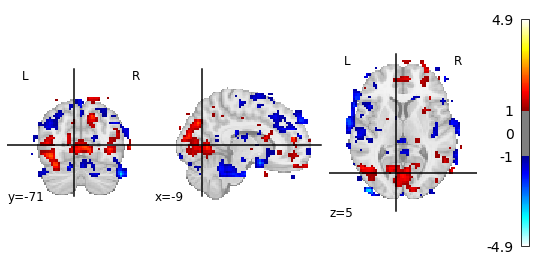

In [4]:
# file = r'C:\Users\izika\OneDrive\Documents\ComDePri\Memory\fMRI data Project\RecallFiles_published\recall_files\sherlock_recall_s1.nii'
if sys.platform == 'linux':
    file = '/home/itzik/Desktop/EventBoundaries/recall_files/sherlock_recall_s1.nii'
else:
    file = r'C:\Users\izika\OneDrive\Documents\ComDePri\Memory\fMRI data Project\RecallFiles_published\recall_files\sherlock_recall_s1.nii'
all_TR = image.load_img(file)
print(all_TR.shape)
first_TR = image.index_img(file, 0)
print(first_TR.shape)

plotting.plot_stat_map(first_TR, threshold=1)#, output_file=output_dir / "first_TR.png")
# first_TR.to_filename(output_dir / "first_TR.nii.gz")

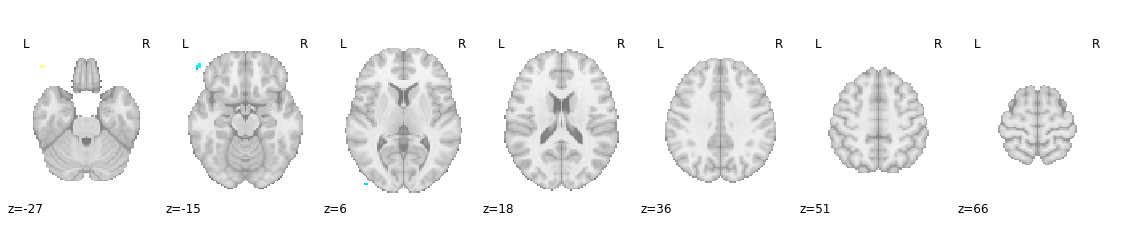

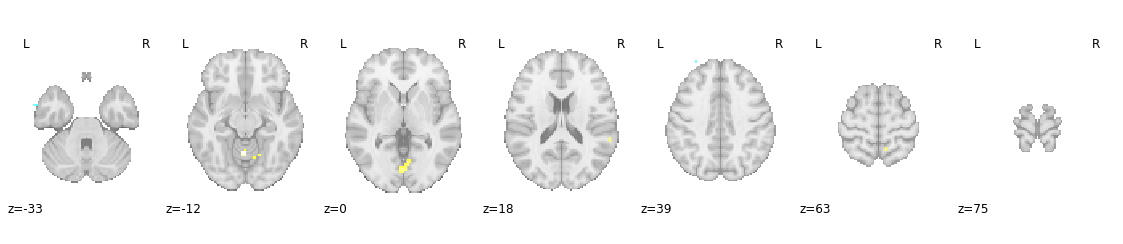

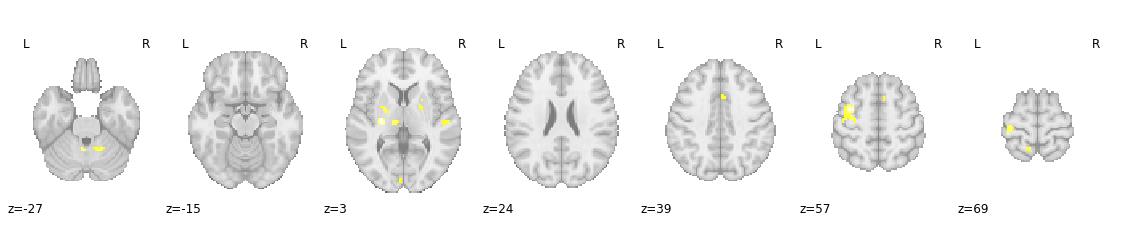

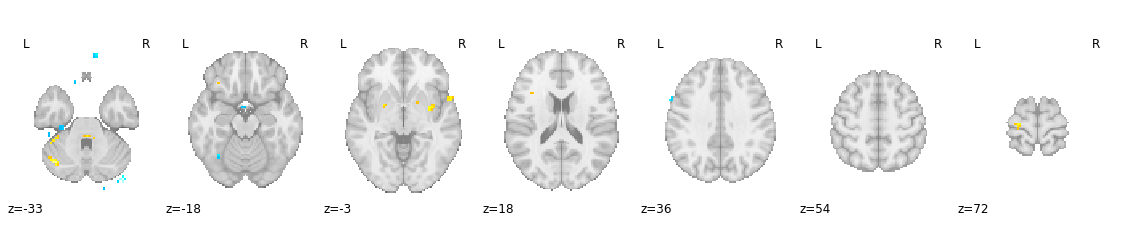

In [351]:
for img in image.iter_img(image.index_img(file, np.arange(0, 4, 1))):
    # img is now an in-memory 3D img
    plotting.plot_stat_map(
        img, threshold=3, display_mode="z",  colorbar=False
    )


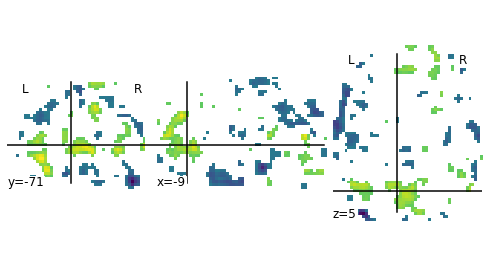

In [352]:
plotting.plot_img(image.smooth_img(first_TR, fwhm=2), threshold=1)

In [5]:
atlas = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr0-2mm") # datasets.fetch_atlas_juelich("maxprob-thr0-2mm")
atlas_surface = datasets.fetch_atlas_surf_destrieux()

# The first label correspond to the background
print(f"The atlas contains {len(atlas.labels) - 1} non-overlapping regions")

The atlas contains 21 non-overlapping regions


# ROI Selection 
### high level regions:
Define DMN ROIs based on Baldassano et al. 2018 (https://www.jneurosci.org/content/38/45/9689), using Yeo 15,16,17 networks and merging spatailly contiguous regions.
This yielded six ROIs: angular gyrus (1868 vertices), superior temporal sulcus (STS, 2118 vertices), SFG (2461 vertices),mPFC (2069 vertices), parahippocampal cortex (PHC, 882 vertices), and PMC (2495 vertices).
 
Additionally, use the freesurfer subcortical parcellation to extract the **hippocampus** as a ROI (Hipp, 1289 voxels).


In [8]:
# resmaple atlas to match 3mm data
atlas.maps = image.resample_to_img(atlas.maps, all_TR, interpolation="nearest")

In [355]:
masker = nl.maskers.NiftiLabelsMasker(
    labels_img=atlas.maps,
    labels=atlas.labels,
    background_label=0,
    mask_img=None,
    smoothing_fwhm=None,
    standardize='zscore',
)

In [356]:
parse = masker.fit_transform(all_TR)

In [357]:
parse[0][label_index]

array([0.01761555, 0.75682443, 0.72814554], dtype=float32)

In [53]:
atlas.labels

['Background',
 'GM Amygdala_centromedial group',
 'GM Amygdala_laterobasal group',
 'GM Amygdala_superficial group',
 'GM Anterior intra-parietal sulcus hIP1',
 'GM Anterior intra-parietal sulcus hIP2',
 'GM Anterior intra-parietal sulcus hIP3',
 "GM Broca's area BA44",
 "GM Broca's area BA45",
 'GM Hippocampus cornu ammonis',
 'GM Hippocampus dentate gyrus',
 'GM Hippocampus entorhinal cortex',
 'GM Hippocampus hippocampal-amygdaloid transition area',
 'GM Hippocampus subiculum',
 'GM Inferior parietal lobule PF',
 'GM Inferior parietal lobule PFcm',
 'GM Inferior parietal lobule PFm',
 'GM Inferior parietal lobule PFop',
 'GM Inferior parietal lobule PFt',
 'GM Inferior parietal lobule PGp',
 'GM Inferior parietal lobule Pga',
 'GM Insula Id1',
 'GM Insula Ig1',
 'GM Insula Ig2',
 'GM Lateral geniculate body',
 'GM Mamillary body',
 'GM Medial geniculate body',
 'GM Premotor cortex BA6',
 'GM Primary auditory cortex TE1.0',
 'GM Primary auditory cortex TE1.1',
 'GM Primary auditory 

In [10]:
# label = ['Right Hippocampus', 'Left Hippocampus'] ; label_index = [atlas.labels.index(l) for l in label]
label = 'hippocampus'; label_index = [atlas.labels.index(l) for l in atlas.labels if 'hippocampus' in l.lower()]
bool_mask = reduce(lambda x, y: x + y, [(atlas.maps.get_fdata() == i) for i in label_index])
mask_img = nl.image.new_img_like(atlas.maps, bool_mask)
print(label, "mask // Shape:", bool_mask.shape, ", # voxels: ", np.sum(bool_mask))

hippocampus mask // Shape: (61, 73, 61) , # voxels:  459
hippocampus mask // Shape: (61, 73, 61) , # voxels:  459


In [56]:
masked = masking.apply_mask([all_TR], mask_img, dtype='f', smoothing_fwhm=None, ensure_finite=True)
masked.shape # TRs x voxels

(847, 2002)

In [11]:
all_TR

In [57]:
np.mean(masked)

2.2838376e-06

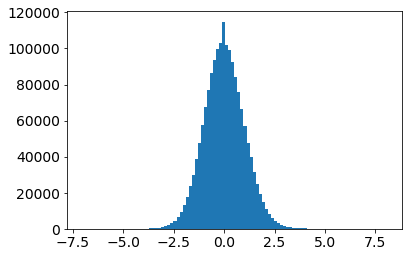

In [58]:
hist = plt.hist(masked.flatten(), bins=100)

In [361]:
# Playing with regions
regs, idx = nl.regions.connected_regions(first_TR, extract_type='local_regions', min_region_size=27, mask_img=atlas.)

SyntaxError: invalid syntax (3400781355.py, line 2)

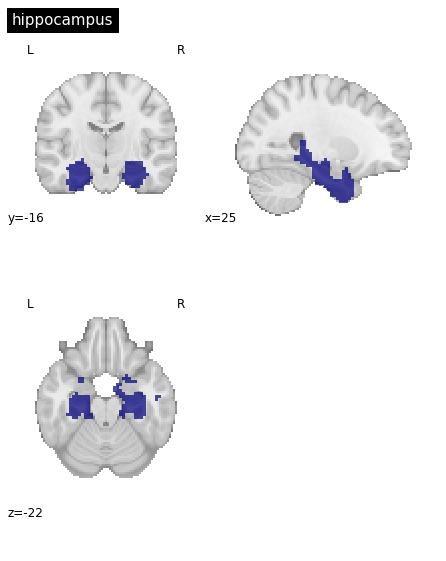

In [59]:
plotting.plot_roi(mask_img, title=label, display_mode='tiled', draw_cross=False)

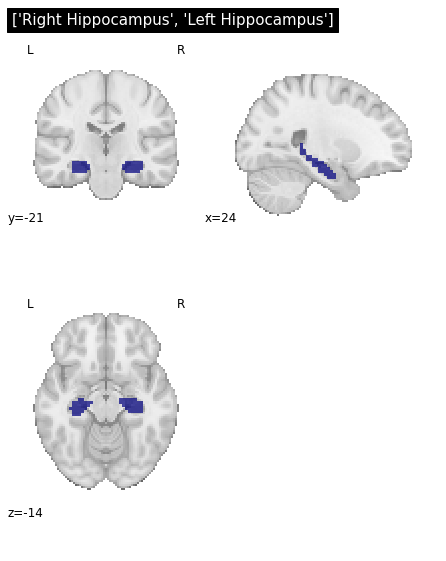

In [50]:
plotting.plot_roi(mask_img, title=label, display_mode='tiled', draw_cross=False)

In [108]:
fsaverage

{'area_left': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/area_left.gii.gz',
 'area_right': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/area_right.gii.gz',
 'curv_left': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/curv_left.gii.gz',
 'curv_right': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/curv_right.gii.gz',
 'flat_left': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/flat_left.gii.gz',
 'flat_right': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/flat_right.gii.gz',
 'infl_left': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/infl_left.gii.gz',
 'infl_right': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/infl_right.gii.gz',
 'pial_left': '/usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/pial_left.gii.gz',
 'pial_right': '/usr/local/lib/python3

In [88]:
# The parcellation is already loaded into memory
parcellation = atlas_surface["map_left"]

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps
# which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# The fsaverage dataset contains file names pointing to the file locations
print(
    "Fsaverage5 pial surface of left hemisphere is at: "
    f"{fsaverage['pial_left']}"
)
print(
    "Fsaverage5 inflated surface of left hemisphere is at: "
    f"{fsaverage['infl_left']}"
)
print(
    "Fsaverage5 sulcal depth map of left hemisphere is at: "
    f"{fsaverage['sulc_left']}"
)


Fsaverage5 pial surface of left hemisphere is at: /usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/pial_left.gii.gz
Fsaverage5 inflated surface of left hemisphere is at: /usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/infl_left.gii.gz
Fsaverage5 sulcal depth map of left hemisphere is at: /usr/local/lib/python3.8/dist-packages/nilearn/datasets/data/fsaverage5/sulc_left.gii.gz


In [113]:
np.sum(atlas_surface["map_left"]==1)

59

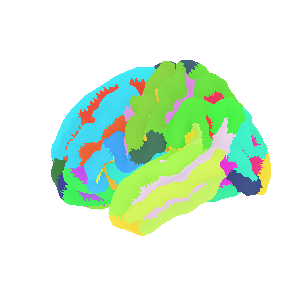

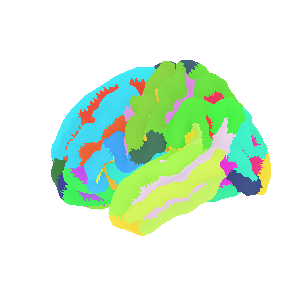

In [122]:
plotting.plot_surf_roi(
    fsaverage["pial_left"],
    roi_map=atlas_surface["map_left"],
    hemi="left",
    view="lateral",
    bg_map=fsaverage["sulc_left"],
    bg_on_data=True,
    darkness=0.5,
)

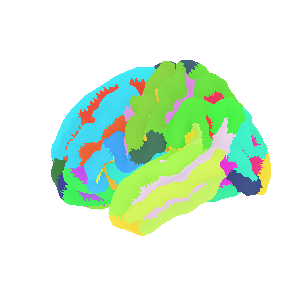

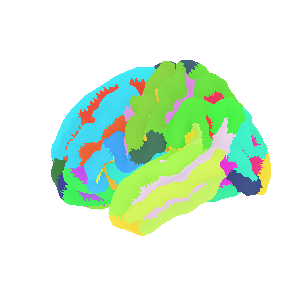

In [126]:
plotting.plot_surf_roi(
    fsaverage["pial_left"],
    roi_map=atlas_surface["map_left"],
    hemi="left",
    view="lateral",
    bg_map=fsaverage["sulc_left"],
    bg_on_data=True,
    darkness=0.5,
)

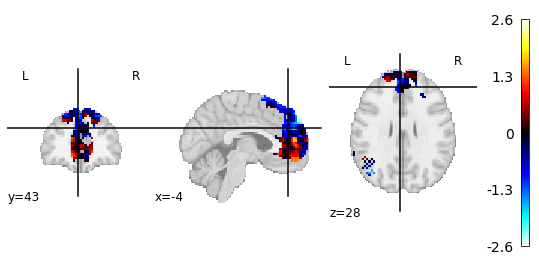

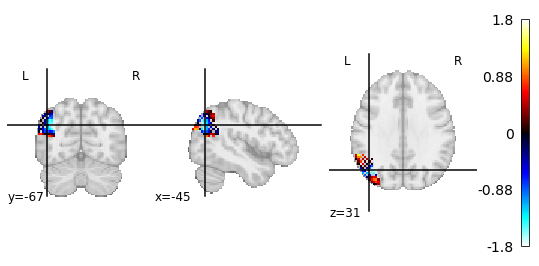

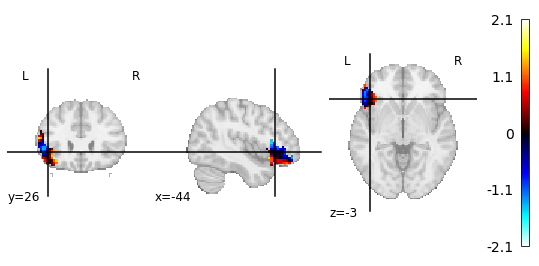

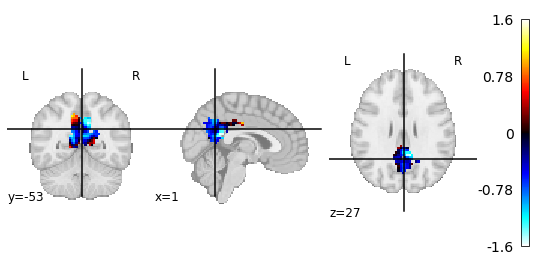

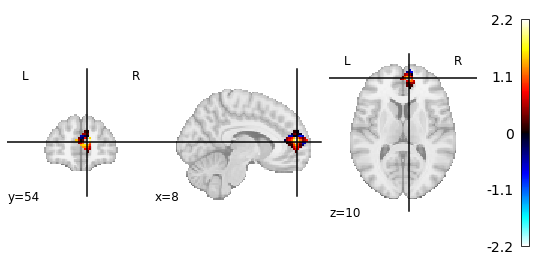

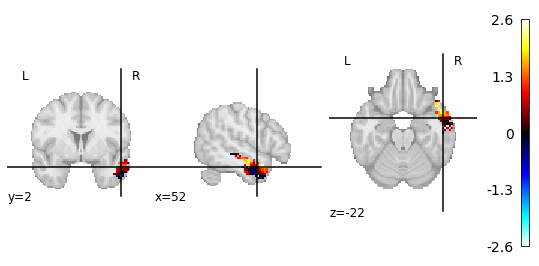

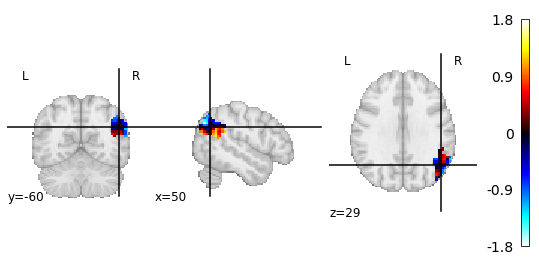

In [363]:
for i in range(regs.shape[-1]):
    plotting.plot_stat_map(image.index_img(regs, i))

In [132]:
lbls_img, lbls = nl.regions.connected_label_regions(atlas.maps, min_size=27)

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

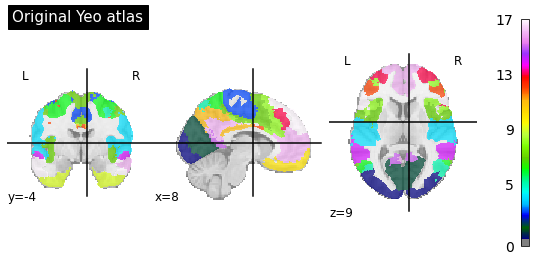

In [16]:
# First we fetch the Yeo atlas
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
atlas_yeo = atlas_yeo_2011.thick_17
yeo_img = image.load_img(atlas_yeo)
plotting.plot_roi(
    atlas_yeo,
    title="Original Yeo atlas",
    cut_coords=(8, -4, 9),
    colorbar=True,
)

In [14]:
atlas_yeo_2011

{'description': ".. _yeo_atlas:\n\nYeo 2011 atlas\n==============\n\nAccess\n------\nSee :func:`nilearn.datasets.fetch_atlas_yeo_2011`.\n\nNotes\n-----\nThis atlas provides a labeling of some cortical voxels in the MNI152\nspace.\n\nFour versions of the atlas are available, according to the cortical\nmodel (thick or thin cortical surface) and to the number of regions\nconsidered (7 or 17).\n\nFor more information on this dataset's structure,\nsee :footcite:t:`CorticalParcellation_Yeo2011`,\nand :footcite:t:`Yeo2011`.\n\nContent\n-------\n    :'anat': Background anatomical image for reference and visualization\n    :'thin_7': Cortical parcelation into 7 regions, thin cortical model\n    :'thin_17': Cortical parcelation into 17 regions, thin cortical model\n    :'thick_7': Cortical parcelation into 17 regions, thick cortical model\n    :'thick_17': Cortical parcelation into 17 regions, thick cortical model\n    :'colors_7': Text file for the coloring of 7-regions parcellation\n    :'colo

In [17]:
yeo_img_resampled = image.resample_to_img(yeo_img, all_TR, interpolation="nearest")

(61, 73, 61, 1)


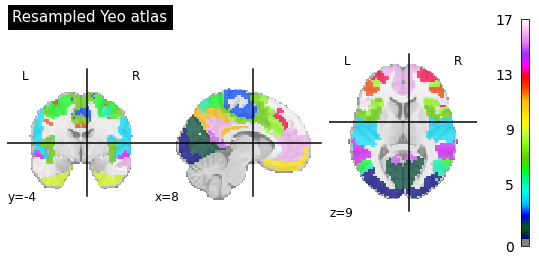

In [18]:
plotting.plot_roi(
    yeo_img_resampled,
    title="Resampled Yeo atlas",
    cut_coords=(8, -4, 9),
    colorbar=True,
)
print(yeo_img_resampled.shape)

In [367]:
# Apply to data abd extract 15,16,17
masker = NiftiLabelsMasker(labels_img=yeo_img_resampled, standardize=True)
yeo_15_16_17 = masker.fit_transform(all_TR)[..., 14:]
print(yeo_15_16_17.shape)


(523, 3)


In [51]:
# manually extract DMN (per Baldassano 2018):
label_index = [15,16,17]
bool_masks = yeo_img_resampled.get_fdata() == label_index
bool_mask = np.sum(bool_masks, axis=-1) > 0
mask_img = nl.image.new_img_like(yeo_img_resampled, bool_mask)
print(str(label_index), "mask // Shape:", bool_mask.shape, ", # voxels: ", np.sum(bool_mask))

[10, 11] mask // Shape: (61, 73, 61) , # voxels:  2279


In [52]:
masked = masking.apply_mask([all_TR], mask_img, dtype='f', smoothing_fwhm=None, ensure_finite=True)

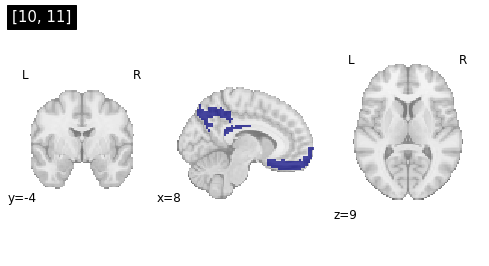

In [53]:
plotting.plot_roi(mask_img, title=str(label_index), display_mode='ortho', draw_cross=False, cut_coords=(8, -4, 9))

In [371]:
# parcelate the data
regs, idx = nl.regions.connected_regions(first_TR, extract_type='local_regions', min_region_size=27, mask_img=mask_img)

In [372]:
regs.shape

(61, 73, 61, 7)

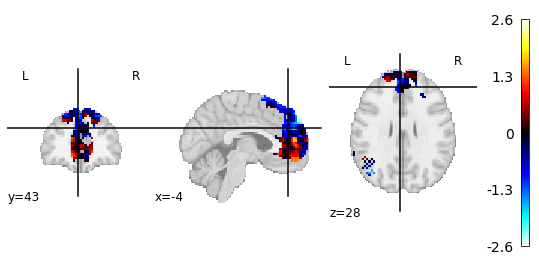

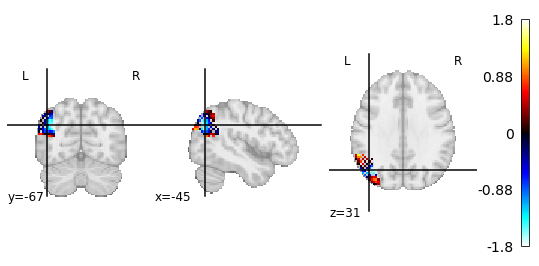

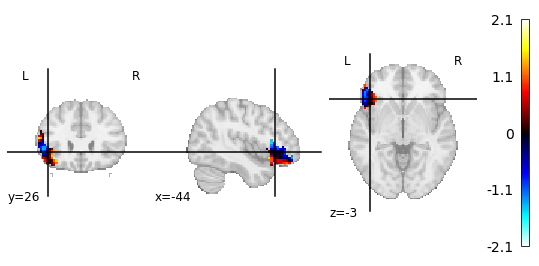

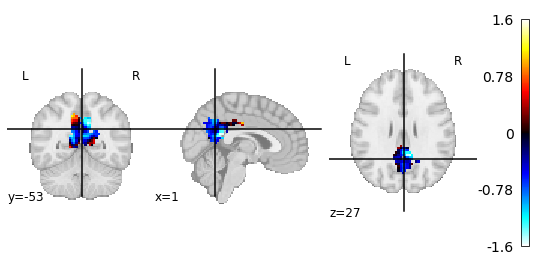

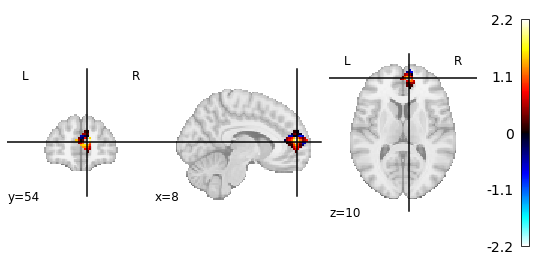

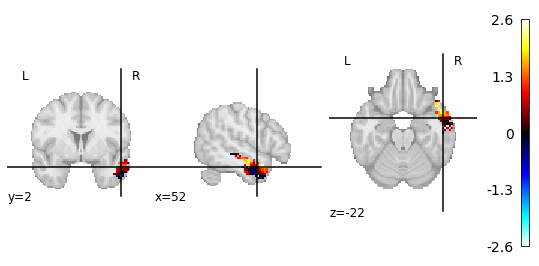

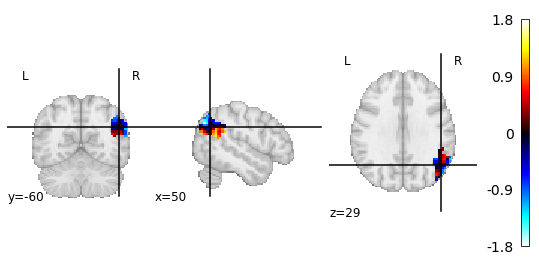

In [373]:
for i in range(regs.shape[-1]):
    plotting.plot_stat_map(image.index_img(regs, i))

# Event Segmentation

In [391]:
masked.shape

(523, 667)

In [419]:
# Create the object
num_events = 4
ev = EventSegment(n_events=num_events)
# Fit the object to the data
ev.fit(masked)
# Extract the boundaries
boundaries = ev.predict(masked) # event num per TR
# print out length of each event
[np.sum(boundaries == i) for i in range(num_events)]

[243, 97, 37, 146]

In [426]:
ev.find_events(masked)[0]

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.89353233e-10, 0.00000000e+00, 0.00000000e+00],
       [9.99999999e-01, 5.13386877e-10, 4.57195721e-20, 0.00000000e+00],
       ...,
       [0.00000000e+00, 8.68721702e-16, 1.41758201e-06, 9.99998582e-01],
       [0.00000000e+00, 0.00000000e+00, 5.75366643e-07, 9.99999425e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

Text(0, 0.5, 'Voxels')

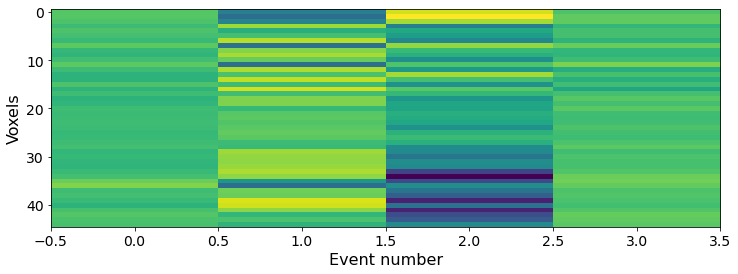

In [417]:
plt.figure(figsize = (12, 4))
example_vox = np.arange(0,ev.event_pat_.shape[0],15)
plt.imshow(ev.event_pat_[example_vox,:], aspect='auto')
plt.xlabel('Event number')
plt.ylabel('Voxels')

Text(0.5, 1.0, 'Event probability')

<Figure size 864x432 with 0 Axes>

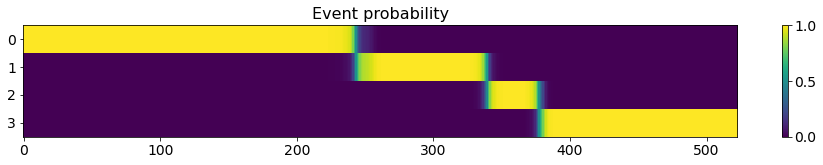

In [418]:
# Plot probability of being in each event at each timepoint
plt.figure(figsize = (12, 6))
plt.matshow(ev.segments_[0].T, aspect='auto')
plt.gca().xaxis.tick_bottom()
plt.colorbar()
plt.title('Event probability')